Imports

In [1]:
import cv2
from keras.datasets import cifar10
import os 
import numpy as np
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from random import randrange
import matplotlib.pyplot as plt
from keras.layers import BatchNormalization

Read data

In [2]:
image_width = 150
image_height = 150
def load_data():
    #read train data
    train_dir = os.path.abspath('dataset/train/images/')             #directory which contains training images
    x_train = []
    y_train = []
    for label, cls in enumerate(os.listdir(train_dir)):               # there is different classes directories in train_dir
        for image_path in os.listdir(train_dir+'/'+cls):
            img = cv2.imread(train_dir+'/'+cls+'/'+image_path)
            # downsample image to 32x32x3 using interpolation
            img = cv2.resize(img, dsize=(image_width,image_height), interpolation = cv2.INTER_AREA) 
            x_train.append(img)
            y_train.append(label)
            
    x_train = np.array(x_train,dtype='float')
    y_train = np.array(y_train)
    
    #read test data
    test_dir = os.path.abspath('dataset/test/images/')             #directory which contains training images
    x_test = []
    y_test = []
    for label, cls in enumerate(os.listdir(test_dir)):               # there is different classes directories in train_dir
        for image_path in os.listdir(test_dir+'/'+cls):
            img = cv2.imread(test_dir+'/'+cls+'/'+image_path)
            # downsample image to 32x32x3 using interpolation
            img = cv2.resize(img, dsize=(image_width,image_height), interpolation = cv2.INTER_AREA) 
            x_test.append(img)
            y_test.append(label)
    x_test = np.array(x_test,dtype='float')
    y_test = np.array(y_test)
    
    return (x_train, y_train), (x_test, y_test), len(os.listdir(test_dir))
    

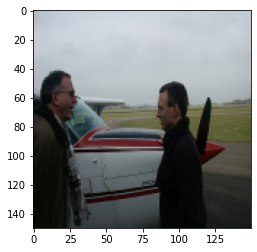

In [3]:
(x_train, y_train), (x_test, y_test), n_classes = load_data()
t= x_train[0]
%matplotlib inline
plt.imshow(cv2.cvtColor((t).astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.show()

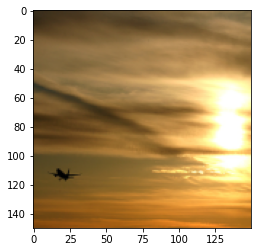

In [4]:
t= x_test[2]
%matplotlib inline
plt.imshow(cv2.cvtColor((t).astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.show()

Preproccesing

In [5]:
def preproccessing(x_train, x_test, y_train, y_test, n_classes):
    #normalize data
    x_train /= 255
    x_test /= 255
    
    #convert label to one hot key model
    y_train = np_utils.to_categorical(y_train, n_classes)
    y_test = np_utils.to_categorical(y_test, n_classes)
    return x_train, x_test, y_train, y_test

In [6]:
x_train, x_test, y_train, y_test = preproccessing(x_train, x_test, y_train, y_test, n_classes)

In [7]:
def rotate(image, angle, center = None, scale = 1.0):
    (h, w) = image.shape[:2]

    if center is None:
        center = (w / 2, h / 2)

    # Perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))

    return rotated

7448


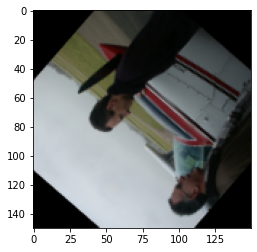

In [8]:
def data_augmentation(x_train, y_train):
    augmentaded_x = []
    augmentaded_y = []
    num_augment = 3
    for count,img in enumerate(x_train):
        augmentaded_x.append(img)
        augmentaded_y.append(y_train[count])
        
        augmentaded_x.append(cv2.flip(img, -1))             #flip the original image
        augmentaded_y.append(y_train[count])
        for i in range(num_augment):
            angle = randrange(180)
            rotaded_image = rotate(img, angle, (image_width/2,image_height/2))                   #rotate image  for the 1st time
            augmentaded_x.append(rotaded_image)
            augmentaded_y.append(y_train[count])

            augmentaded_x.append(cv2.flip(rotaded_image, 0))             #flip the rotated 1 image
            augmentaded_y.append(y_train[count])

            augmentaded_x.append(cv2.flip(rotaded_image, 1))             #flip the rotated 1 image
            augmentaded_y.append(y_train[count])

            augmentaded_x.append(cv2.flip(rotaded_image, -1))             #flip the rotated 1 image
            augmentaded_y.append(y_train[count])
        
        
    augmentaded_x = np.array(augmentaded_x,dtype='float')
    augmentaded_y = np.array(augmentaded_y,dtype='float')
    
    return augmentaded_x,augmentaded_y

x_train, y_train = data_augmentation(x_train, y_train)
print(len(y_train))
t= x_train[2]
%matplotlib inline
plt.imshow(cv2.cvtColor((t*255).astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.show()

create model

In [9]:
# model = Sequential()

# # convolutional layer
# model.add(Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(image_width, image_height, 3)))

# # convolutional layer
# model.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# # flatten output of conv
# model.add(Flatten())

# # hidden layer
# model.add(Dense(250, activation='relu'))
# model.add(Dropout(0.4))
# model.add(Dense(250, activation='relu'))
# model.add(Dropout(0.3))
# # output layer
# model.add(Dense(19, activation='softmax'))

# # compiling the sequential model
# model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# # training the model for 10 epochs
# model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))

### Transfer learning

In [10]:
from keras.applications import VGG16

# include top should be False to remove the softmax layer
pretrained_model = VGG16(include_top=False, weights='imagenet')
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [11]:
from keras.utils import to_categorical
# extract train and val features
vgg_features_train = pretrained_model.predict(x_train)
vgg_features_val = pretrained_model.predict(x_test)

In [12]:
model2 = Sequential()
model2.add(Flatten(input_shape=(4,4,512)))
model2.add(Dense(200, activation='relu'))
model2.add(Dropout(0.25))
model2.add(Dense(50, activation='relu'))
model2.add(Dropout(0.25))
model2.add(BatchNormalization())
model2.add(Dense(19, activation='softmax'))

# compile the model
# model2.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')
model2.compile(optimizer='adam', metrics=['accuracy','top_k_categorical_accuracy'], loss='categorical_crossentropy')

model2.summary()

# train model using features generated from VGG16 model
model2.fit(vgg_features_train, y_train, epochs=15, batch_size=20, validation_data=(vgg_features_val, y_test))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 200)               1638600   
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
dense_2 (Dense)              (None, 19)                9

In [ ]:
vgg_features_train.shape

In [ ]:
vgg_features_val.shape

In [ ]:
y_train[3000:8000]

In [ ]:
t= x_test[3]
%matplotlib inline
plt.imshow(cv2.cvtColor((t*255).astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# # keras imports for the dataset and building our neural network
# from keras.datasets import cifar10
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
# from keras.utils import np_utils

# # loading the dataset
# (X_train, y_train), (X_test, y_test) = cifar10.load_data()

# # # building the input vector from the 32x32 pixels
# X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
# X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')

# # normalizing the data to help with the training
# X_train /= 255
# X_test /= 255

# # one-hot encoding using keras' numpy-related utilities
# n_classes = 10
# print("Shape before one-hot encoding: ", y_train.shape)
# Y_train = np_utils.to_categorical(y_train, n_classes)
# Y_test = np_utils.to_categorical(y_test, n_classes)
# print("Shape after one-hot encoding: ", Y_train.shape)

# # building a linear stack of layers with the sequential model
# model = Sequential()

# # convolutional layer
# model.add(Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(32, 32, 3)))

# # convolutional layer
# model.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# # flatten output of conv
# model.add(Flatten())

# # hidden layer
# model.add(Dense(500, activation='relu'))
# model.add(Dropout(0.4))
# model.add(Dense(250, activation='relu'))
# model.add(Dropout(0.3))
# # output layer
# model.add(Dense(10, activation='softmax'))

# # compiling the sequential model
# model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# # training the model for 10 epochs
# model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_test, Y_test))